In [1]:
import random 
import simpy
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sty import fg
from scipy.stats import poisson 
import mpu
import math
import csv
import intervals as I

C:\Users\jalal\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


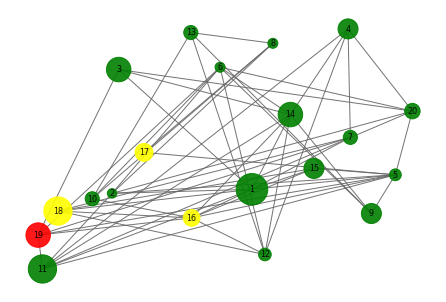

In [2]:
random.seed(123)


places_set_1 = {
          0:  "1",
          1:  "2",
          2:  "3",
          3:  "4",
          4:  "5",
          5:  "6",
          6:  "7",
          7:  "8",
          8:  "9",
          9:  "10",
          10: "11",
          11: "12",
          12: "13",
          13: "14",
          14: "15",
          15: "20"
}

places_set_2 = {
          16: "16",
          17: "17",
          18: "18"
}

places_set_3 = {
          19: "19" 
}

vehicles_set_1 = {
            "Bicycle"                : 30,
            "Motorbike"              : 45,
            "Automobile Type 1"      : 80,
            "Taxi"                   : 70,
            "Bus"                    : 60,
            "Metro Normal Speed"     : 100
}

vehicles_set_2 = {
            "Automobile Type 2"      : 120,
            "Metro High Speed"       : 110
}

vehicles_set_3 = {
            "Automobile Type 3"      : 140
}


places_capacity = {
           "1"      : 500,
           "2"      : 45,
           "3"      : 300,
           "4"      : 200,
           "5"      : 70,
           "6"      : 50,
           "7"      : 100,
           "8"      : 50,
           "9"      : 200,
           "10"     : 100,
           "11"     : 400,
           "12"     : 80,
           "13"     : 100,
           "14"     : 300,
           "15"     : 200,
           "16"     : 140,
           "17"     : 160,
           "18"     : 400,
           "19"     : 300,
           "20"     : 120
}
######################################################################


#get the merged dictionary of places
places = {**places_set_1, **places_set_2, **places_set_3}

#get the merged dictionary of vehicles
vehicles = {**vehicles_set_1, **vehicles_set_2, **vehicles_set_3}


######################################################################

#generate the random network
n = 20
p = 0.3
H = nx.erdos_renyi_graph(n, p)


    
#relabel the generated network
G = nx.relabel_nodes(H, places)

# We have to set the places capacity attribute for each of the nodes
for i in list(G.nodes()):
    G.nodes[i]["places_capacity"] = places_capacity[i] 
    
# node colour based on value
color_map = []

for node in G:
    if node in places_set_1.values():
        color_map.append('green')
    elif node in places_set_2.values():
        color_map.append('yellow') 
    else:
        color_map.append('red')

# size of node is a list of places capacity 
node_size = [2 * nx.get_node_attributes(G, "places_capacity")[v] for v in G]

######################################################################
#generating a list of random but realistic geometric coordinates  

def newcoordinates():
    return random.uniform(-19,-20), random.uniform(15, 16)

coordinates = []
coord = (newcoordinates() for x in range(20))
for coordinate in coord:
    coordinates.append(coordinate)


##################################################################### 
#generating a dictionary of nodes with their corresponding coordinates 

places_list = [
           "1",
           "2",
           "3",
           "4",
           "5",
           "6",
           "7",
           "8",
           "9",
           "10",
           "11",
           "12",
           "13",
           "14",
           "15",
           "16",
           "17",
           "18",
           "19",
           "20"
]

places_coordinates = dict(zip(places_list, coordinates))
#####################################################################
#draw the network
nx.draw(G, places_coordinates, node_color = color_map, node_size = node_size, alpha = 0.9,
        font_size = 8, with_labels = True, edge_color ='.4', cmap = plt.cm.Blues) 
   
plt.show()  

In [3]:
graph_edges_1= list(G.edges())
graph_edges_2 = [t[::-1] for t in graph_edges_1]

graph_edges = graph_edges_1 + graph_edges_2

In [4]:
df = nx.to_pandas_adjacency(G)
df.to_csv("AoI graph-DRL.csv")

In [5]:
def city_start (env, person_id, csv_writer):
        
        #start time for each person considering hours and time in a day
        path_start_time = random.random()
        
        if path_start_time <= 0.1:
            start_time = random.randint(0, 6*60)
            yield env.timeout(start_time) 
            arrival_time = env.now
            
        elif path_start_time <= 0.8 and path_start_time > 0.1:
            start_time = random.randint(6*60, 21*60)
            yield env.timeout(start_time)
            arrival_time = env.now
            
        else:
            start_time = random.randint(21*60, 24*60)
            yield env.timeout(start_time)
            arrival_time = env.now

        stop_time = random.randint(10, 200)
        yield env.timeout(stop_time) #stop time
        
        departure_time = env.now
        
        unwanted_node = {'11', '6', '7', '19', '3', '5'}
        origin = random.choice([ele for ele in places_list if ele not in unwanted_node])
        
        nextDestination = origin
        
        
        visited_places_arrival_time = [arrival_time]
        visited_places_departure_time = [departure_time]
        visited_nodes = [origin]
        visited_travel_time = []
        visited_places_interval = []
        visited_places_stay_time = [stop_time]
       
        while departure_time < (24*60):
            
            
            if nextDestination != places_set_3.get(19):

                #find the list of nodes connected to the node currently at hand
                connected_nodes_to_origin = [n for n in G.neighbors(origin)]
                
                if "19" in connected_nodes_to_origin:
                    nextDestination = places_set_3.get(19)
                    
                else:
                    #choose the next destination among the list obtained
                    nextDestination = connected_nodes_to_origin[random.randint(0, len(connected_nodes_to_origin)-1)]

                #get the coordinates of both nodes corresponding to the edge    
                origin_position = places_coordinates.get(origin)
                nextDestination_position = places_coordinates.get(nextDestination)

                #find the distance between the two connected nodes 
                distance = round(mpu.haversine_distance(origin_position, nextDestination_position), 1)

                #choose the mode of transportation and its corressponding average speed randomly 
                average_speed = vehicles[random.choice(list(vehicles))]

                for vehicle_type, avg_speed in vehicles.items(): 
                    if avg_speed == average_speed:
                         vehicle = vehicle_type

                # calculate the trip time 
                travel_time = (distance / average_speed)*60
                yield env.timeout(travel_time)

                arrival_time = env.now
                
                # stop time
                stop_time = random.randint(10, 200)
                yield env.timeout(stop_time) #stop time

                departure_time = env.now

                origin  = nextDestination

                visited_nodes.append(nextDestination)
                visited_places_interval.append(distance)
                visited_places_stay_time.append(stop_time)
                visited_places_arrival_time.append(arrival_time)
                visited_places_departure_time.append (departure_time)
                visited_travel_time.append(travel_time)
                path_class = 0

            else:
                
#                 print ("---------------------------------------") 
#                 print ("visited places by person ID", person_id, "is", visited_nodes)
#                 print ("distance between places visited repectively:", visited_places_interval)
#                 print ("arrival time for places visited repectively:", visited_places_arrival_time)
#                 print ("stop/stay time for places visited repectively:", visited_places_stay_time)
#                 print ("departure time for places visited repectively:", visited_places_departure_time)
#                 print ("travel time for visited places:", visited_travel_time)
#                 
                #parent graph
#                 nx.draw(G, places_coordinates, node_color = color_map, node_size = node_size, alpha = 0.9,
#                       font_size = 8, with_labels = True, edge_color ='.4', cmap = plt.cm.Blues)
                
                #create the path
                path = visited_nodes
                path_edges = list(zip(path,path[1:]))
#                 print(path_edges)
                
                row_of_edges = []
                for edge in graph_edges:
                    if edge not in path_edges:
                        row_of_edges.append(0)
                    else:
                        row_of_edges.append(1)
                        
#                 print("row of edges:", row_of_edges)
                        
#                 nx.draw_networkx_nodes(G, places_coordinates, nodelist = path, node_color = 'none')
#                 nx.draw_networkx_edges(G, places_coordinates, edgelist = path_edges, edge_color = 'k',
#                                        width = 3, arrows = True, arrowstyle = '-|>')
#                 plt.axis('equal')
#                 plt.show()
                
                #write to CSV file            
                csv_writer.writerow(row_of_edges + [arrival_time, departure_time, path_class])
                    
                break
                
        else:
            pass
       
  
                 

        

def run_day_in_city(env, num_persons):
    
    csv_file = open('random paths.csv', 'w', newline='') 
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(graph_edges + ['Arrival Time', 'Departure Time', 'Class'])
    
    for person in range(num_persons):
            env.process(city_start(env, person, csv_writer))
            yield env.timeout(poisson.rvs(0.002))  #time between generating a new person

In [6]:
print ("Time is in minutes")
print ("Distance is in miles")
print ("Average speed is in mph")
print ("===========================")
num_persons = 10000
env=simpy.Environment()
env.process(run_day_in_city(env, num_persons))
env.run(until = 24*60*10000)

Time is in minutes
Distance is in miles
Average speed is in mph
